read model output
evaluate
Calib
NSE=0.88, Bias=1.12, Variance=1.01, Correlation=0.95, KGE=0.88
plot


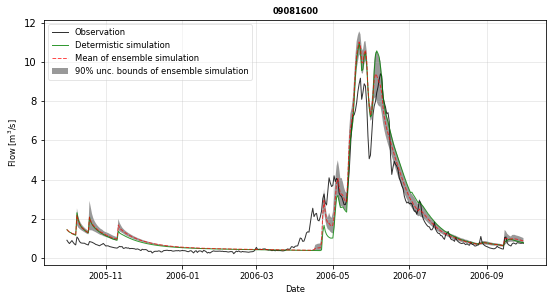

Done


In [2]:
# compare simulated and observed flow
import os
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 
import matplotlib as mpl
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
#================================ Plot =======================================
def read_output(file):    
    # read csv
    time = np.loadtxt(file, usecols=[0,1,2], dtype='str', skiprows=1)
    data = np.loadtxt(file, usecols=[-2,-1], skiprows=1) #sim, obs
    data[data<0]=np.nan
    
    # convert time
    dt = []
    for i in range(len(time)):
        t_str = time[i,0]+' '+time[i,1]+' '+time[i,2]
        dt.append(datetime.strptime(t_str,'%Y %m %d'))
        
    # create dataframe (time, data)
    df = pd.DataFrame(data,columns=['sim','obs'])
    df['Date'] = dt
    df = df.set_index('Date')  
    return df

def read_ens_output(ens_out_dir):    
    # read file
    files = [f for f in os.listdir(ens_out_dir) if '_output_' in f]
    ens_num = len(files)
    
    for i in range(ens_num):
        file = os.path.join(ens_out_dir, files[i])
        if i == 0:
            time = np.loadtxt(file, usecols=[0,1,2], dtype='str', skiprows=1)
            obs = np.loadtxt(file, usecols=[-1], skiprows=1)
            ens_sim = np.zeros((len(obs), ens_num))
        sim = np.loadtxt(file, usecols=[-2], skiprows=1)
        ens_sim[:,i]=sim
        
        obs[obs<0]=np.nan
        ens_sim[ens_sim<0]=np.nan
    
    # convert time
    dt = []
    for i in range(len(time)):
        t_str = time[i,0]+' '+time[i,1]+' '+time[i,2]
        dt.append(datetime.strptime(t_str,'%Y %m %d'))
        
    # create dataframe (time, data)
    obs_df = pd.DataFrame(obs,columns=['obs'])
    obs_df['Date'] = dt
    obs_df = obs_df.set_index('Date')  
    
    sim_df = pd.DataFrame(ens_sim)
    sim_df['Date'] = dt
    sim_df = sim_df.set_index('Date')  
    return obs_df, sim_df

def plot_hyd(obs_df, sim_df, title_str, ylabel, ofile):
    
    row_num=1
    col_num=1        
    fig, ax = plt.subplots(row_num,col_num,figsize=[9, 9*0.5])

    dpi_value=150
    obs_df.plot(ax=ax, color='black', linestyle='-', linewidth=1.0, markersize=0.0, alpha=0.8)
    sim_df.plot(ax=ax, color='r', linestyle='--', linewidth=1.0, markersize=0.0, alpha=0.8)

    #axis, label, title, legend
    ax.set_title(title_str, fontsize='small', fontweight='bold')
    ax.set_xlabel('Date', fontsize='small')
    ax.set_ylabel(ylabel, fontsize='small')
    
    ax.xaxis.set_tick_params(labelsize='small')
    ax.legend(loc='best', fontsize='small', framealpha=0.5) 

    plt.rc('xtick',labelsize='small')
    plt.rc('ytick',labelsize='small') 
    plt.grid(True,linewidth=0.5,alpha=0.5)
    plt.show()
    
    fig.tight_layout()
    fig.savefig(ofile, dpi=dpi_value)
    plt.close(fig)      
    
    return 

def plot_hyd_ens(obs_df, sim_df, ens_sim_df, title_str, ylabel, ofile):
    
    row_num=1
    col_num=1        
    fig, ax = plt.subplots(row_num,col_num,figsize=[9, 9*0.5])
    dpi_value=150
    
    t_plot = obs_df.index
    obs = obs_df.to_numpy()
    sim = sim_df.to_numpy()    
    ens_sim_arr = ens_sim_df.to_numpy()
    
    ens_sim_mean = np.nanmean(ens_sim_arr,axis=1)
    ens_sim_lb = np.nanpercentile(ens_sim_arr,5,axis=1)
    ens_sim_ub = np.nanpercentile(ens_sim_arr,95,axis=1)

    ax.plot_date(t_plot, obs, color='black', linestyle='-', linewidth=1.0, markersize=0.0, alpha=0.8, label='Observation') 
    ax.plot_date(t_plot, sim, color='green', linestyle='-', linewidth=1.0, markersize=0.0, alpha=0.8, label='Determistic simulation') 
    ax.plot_date(t_plot, ens_sim_mean, color='r', linestyle='--', linewidth=1.0, markersize=0.0, alpha=0.7, label='Mean of ensemble simulation') 
    ax.fill_between(t_plot, ens_sim_lb, ens_sim_ub, linewidth=0, facecolor='grey', alpha=0.8, label='90% unc. bounds of ensemble simulation')

    #axis, label, title, legend
    ax.set_title(title_str, fontsize='small', fontweight='bold')
    ax.set_xlabel('Date', fontsize='small')
    ax.set_ylabel(ylabel, fontsize='small')
    
    ax.xaxis.set_tick_params(labelsize='small')
    ax.legend(loc='best', fontsize='small', framealpha=0.5) 

    plt.rc('xtick',labelsize='small')
    plt.rc('ytick',labelsize='small') 
    plt.grid(True,linewidth=0.5,alpha=0.5)
    plt.show()
    
    fig.tight_layout()
    fig.savefig(ofile, dpi=dpi_value)
    plt.close(fig)      
    
    return 

def get_modified_KGE(obs,sim):
    obs = np.asarray(obs)
    sim = np.asarray(sim)
    sim = np.reshape(sim, np.shape(obs))
    
    obs_cal = obs[~np.isnan(obs)]
    sim_cal = sim[~np.isnan(obs)]
    
    sd_sim=np.std(sim_cal, ddof=1)
    sd_obs=np.std(obs_cal, ddof=1)
    
    m_sim=np.mean(sim_cal)
    m_obs=np.mean(obs_cal)
    
    corr=(np.corrcoef(sim_cal,obs_cal))[0,1]
    var=(float(sd_sim)/float(m_sim))/(float(sd_obs)/float(m_obs))
    bias=float(m_sim)/float(m_obs)
    
    kge=1.0-np.sqrt((corr-1)**2 +(var-1)**2 + (bias-1)**2)
    return bias, var, corr, kge


def get_NSE(obs,sim):
    obs = np.asarray(obs)
    sim = np.asarray(sim)
    sim = np.reshape(sim, np.shape(obs))
    
    obs_cal = obs[~np.isnan(obs)]
    sim_cal = sim[~np.isnan(obs)]
    
    sd_sim=np.std(sim_cal, ddof=1)
    sd_obs=np.std(obs_cal, ddof=1)
    
    m_sim=np.mean(sim_cal)
    m_obs=np.mean(obs_cal)
    
    corr=(np.corrcoef(sim_cal,obs_cal))[0,1]
    var=float(sd_sim)/float(sd_obs)
    bias=(m_sim-m_obs)/float(sd_obs)
    
    nse = - bias**2 - var**2 + 2*var*corr
    return nse

#===============================================================================
# Main script
root_dir = '/glade/u/home/hongli/scratch/2020_04_21nldas_gmet/scripts/snow17_sac'
gage_id='09081600' # crystal
# gage_id='13310700' # salmon

sim_output_dir = '/glade/u/home/hongli/scratch/2020_04_21nldas_gmet/ens_sim'
determ_ofile = os.path.join(sim_output_dir,'determ_output',gage_id+'_output.txt')
ens_sim_dir = os.path.join(sim_output_dir,'ens_output',gage_id)

start_time = '2005/10/01'
end_time = '2006/09/30'
time_fmt = '%Y/%m/%d'
start_time_obj = datetime.strptime(start_time,time_fmt)
end_time_obj = datetime.strptime(end_time,time_fmt)

output_dir=os.path.join(root_dir,'4_plot_ens_output')
output_file_basename = gage_id+'_Hydrograph_'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# read output 
print('read model output')
df = read_output(determ_ofile)
obs_df, ens_sim_df = read_ens_output(ens_sim_dir)

df = df[start_time_obj:end_time_obj]
obs_df = obs_df[start_time_obj:end_time_obj]
ens_sim_df = ens_sim_df[start_time_obj:end_time_obj]

# evaluate
print('evaluate')
nse = get_NSE(df['obs'].values,df['sim'].values)
bias,var,corr,kge = get_modified_KGE(df['obs'].values,df['sim'].values)
print(('Calib\nNSE=%.2f, Bias=%.2f, Variance=%.2f, Correlation=%.2f, KGE=%.2f')%(nse,bias,var,corr,kge))

# plot 
print('plot')
title_str = gage_id
ofile = os.path.join(output_dir, output_file_basename+'_ens.png')
# plot_hyd(df['obs'], df['sim'], title_str, 'Flow [m$^3$/s]',ofile)
plot_hyd_ens(df['obs'], df['sim'], ens_sim_df, title_str, 'Flow [m$^3$/s]',ofile)

print('Done')

In [3]:
df[start_time_obj:end_time_obj]

,sim,obs
Date,,
2005-10-01,1.098234,0.332193
2005-10-02,1.845336,0.426696
2005-10-03,2.426056,0.409513
2005-10-04,2.391467,0.398058
2005-10-05,2.010506,0.363694
...,...,...
2006-09-26,1.543205,0.375148
2006-09-27,1.429361,0.369421
2006-09-28,1.349261,0.363694


In [4]:
df

,Dayl(s),PRCP(mm/day),SRAD(W/m2),SWE(mm),Tmax(C),Tmin(C),Vp(Pa)
Date,,,,,,,
1980-01-01,31236.10,9.68,131.43,0.0,-1.03,-1.03,517.04
1980-01-02,31308.86,1.31,188.29,0.0,-3.96,-3.96,402.22
1980-01-03,31407.67,2.68,194.72,0.0,-2.30,-2.30,450.44
1980-01-04,31449.60,5.02,144.25,0.0,-2.80,-2.80,453.40
1980-01-05,31449.60,27.12,115.70,0.0,-1.29,-1.29,487.83
...,...,...,...,...,...,...,...
2014-12-27,31104.00,0.00,146.20,0.0,-10.40,-10.40,240.21
2014-12-28,31104.00,12.71,164.88,0.0,-5.86,-5.86,337.70
2014-12-29,31104.00,2.17,176.54,0.0,-8.05,-8.05,288.81


In [6]:
df[start_time_obj:end_time_obj] 

,Dayl(s),PRCP(mm/day),SRAD(W/m2),SWE(mm),Tmax(C),Tmin(C),Vp(Pa)
Date,,,,,,,
